When encountering the term Autoencoder for the first time, one might wonder, Is it like an SVD with non-linear twists?. Autoencoders are neural networks designed to learn compact representations of data. Their architecture consists of an encoder (which compresses input data) and a decoder (which reconstructs the original data). The goal? To find a lower-dimensional representation (the “bottleneck”) that captures essential features. Singular Value Decomposition (SVD) is a mathematical technique that decomposes a matrix into three components: $U$ , $\Sigma$, and $V$. The matrix $\Sigma$ contains the singular values, which determine each component’s importance. 

SVD operates linearly—no fancy activation functions. Unlike the linear SVD, autoencoders embrace non-linearity. By using activation functions like ReLU or sigmoid, they capture complex relationships in the data.

 
$
\begin{array}{|l|l|}
\hline
\textbf{Application} & \textbf{SVD} & \textbf{Autoencoder} \\
\hline
\text{Data Compression} & \text{Compresses data by retaining significant singular values.} & \text{Reduces high-dimensional data into a manageable form.} \\
\hline
\text{Image Recognition} & \text{Used for face recognition and image compression.} & \text{Denoises corrupted data.} \\
\hline
\text{Collaborative Filtering} & \text{Uncovers latent factors in user-item interactions.} & \text{N/A} \\
\hline
\text{Dimensionality Reduction} & \text{N/A} & \text{Excels at dimensionality reduction.} \\
\hline
\text{Noise Reduction} & \text{N/A} & \text{Denoises data by learning robust representations.} \\
\hline
\text{Image Generation} & \text{N/A} & \text{VAEs create new data samples.} \\
\hline
\end{array}
$

In [1]:
##Credict Card froud detection using autoencoder

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import polars as pl
from torch.optim import lr_scheduler

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D


In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Fraud detection with an Autoencoder


The task of fraud detection for unsupervised data, particularly for credit card transactions, can be managed with a novel deep neural network approach. This can serve as an experimental case using data from a Kaggle dataset. The goal is to employ an autoencoder to learn a latent representation of the data.

In this case, the process should be as follows: First, train the autoencoder for feature extraction using nn.MSELoss() to reconstruct the input data. The features learned by the autoencoder (i.e., the encoded representation) can then be used for further analysis or modeling.

In [3]:
main_path = "credit_card/creditcard_2023.csv"

In [5]:
df = pd.read_csv(main_path)
#df = pl.read_csv(main_path)
df

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568625,568625,-0.833437,0.061886,-0.899794,0.904227,-1.002401,0.481454,-0.370393,0.189694,-0.938153,...,0.167503,0.419731,1.288249,-0.900861,0.560661,-0.006018,3.308968,0.081564,4394.16,1
568626,568626,-0.670459,-0.202896,-0.068129,-0.267328,-0.133660,0.237148,-0.016935,-0.147733,0.483894,...,0.031874,0.388161,-0.154257,-0.846452,-0.153443,1.961398,-1.528642,1.704306,4653.40,1
568627,568627,-0.311997,-0.004095,0.137526,-0.035893,-0.042291,0.121098,-0.070958,-0.019997,-0.122048,...,0.140788,0.536523,-0.211100,-0.448909,0.540073,-0.755836,-0.487540,-0.268741,23572.85,1
568628,568628,0.636871,-0.516970,-0.300889,-0.144480,0.131042,-0.294148,0.580568,-0.207723,0.893527,...,-0.060381,-0.195609,-0.175488,-0.554643,-0.099669,-1.434931,-0.159269,-0.076251,10160.83,1


### Data Normalization and Standarization 


Normalization and standardization are crucial preprocessing steps. Normalizing the "Amount" column ensures all features are on a similar scale, improving performance and convergence. Standardizing data based on the mean and standard deviation of the training set ensures that both training and test data are on the same scale, enhancing model generalization and accuracy. These steps help algorithms perform better, especially those sensitive to feature scales, and handle outliers more effectively.
### Data filtering
Filtering non-fraudulent data (Class = 0) from the training set is important because it allows the model to focus more effectively on detecting fraudulent transactions, which are typically rare. By excluding these non-fraudulent examples, we can reduce computational complexity, address class imbalance, and improve the model's sensitivity to the minority class of fraudulent transactions. This targeted approach helps in balancing the dataset and enhances the model's performance in identifying fraud.

In [28]:

# Normalize the "Amount" column
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))


# Extract features and labels from the entire dataset
X = df.drop(["id", "Class"], axis=1).values  
y = df["Class"].values


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Filter non-fraudulent data (Class = 0) from the training set
X_train = X_train[y_train == 0]
y_train = y_train[y_train == 0]

# Display dimensions to verify
print("Dimensions of X_train_non_fraud:", X_train.shape)
print("Dimensions of X_test:", X_test.shape)
print("Dimensions of y_train_non_fraud:", y_train.shape)
print("Dimensions of y_test:", y_test.shape)

# #Standarize data based on mean & std of X_train
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train = (X_train -mean)/std
X_test = (X_test -mean)/std

# Pass the data to tensors

X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train)  
y_test_tensor = torch.LongTensor(y_test)    


# Create DataLoader to handle data in batches
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


bs = 64
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=bs,
    shuffle=True,
    num_workers=8)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=bs,
    shuffle=False,
    num_workers=8)


Dimensions of X_train_non_fraud: (255816, 29)
Dimensions of X_test: (56863, 29)
Dimensions of y_train_non_fraud: (255816,)
Dimensions of y_test: (56863,)


## What is PCA?

Principal Component Analisis (PCA) is a statistical procedure that transforms a dataset into a set of orthogonal (uncorrelated) components, called principal components. These components are ordered by the amount of variance they capture from the data. The first principal component captures the most variance, the second captures the second most, and so on.

Essentially I will going to project the high-dimensional data (before and after reconstruction) onto a lower-dimensional space for an easier interpretation. This can help in understanding how well the autoencoder is reconstructing the data by showing whether the reconstructed samples align with the original test samples in the reduced PCA space.

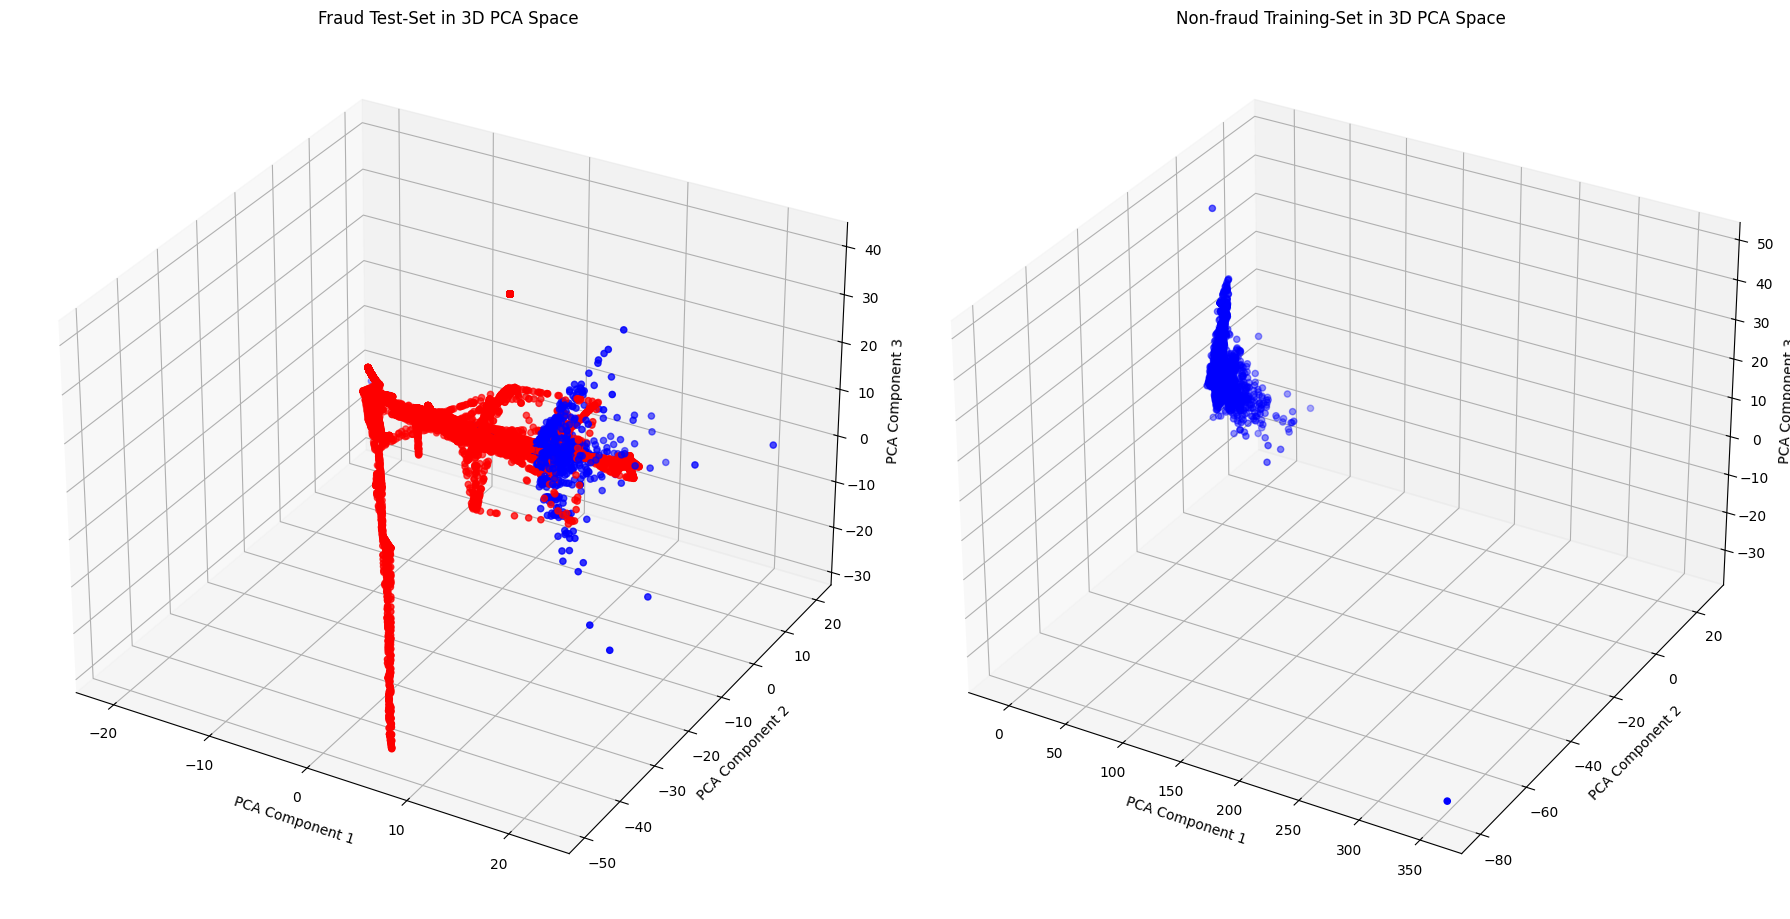

In [68]:
# Dimensionality reduction to 3 principal components
pca = PCA(n_components=3)
X_test_reduced1 = pca.fit_transform(X_test)
X_test_reduced2 = pca.fit_transform(X_train)

# Colors for points: 'r' for anomalies and 'b' for normal
colors_normal_train = ['r' if x == 1 else 'b' for x in y_test]
colors_test_train = ['r' if x == 1 else 'b' for x in y_train]

# Figure and axes setup
fig = plt.figure(figsize=(18, 12))

# First plot
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(X_test_reduced1[:, 0], X_test_reduced1[:, 1], X_test_reduced1[:, 2],
                       c=colors_normal_train, marker='o')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.set_zlabel('PCA Component 3')
ax1.set_title('Fraud Test-Set in 3D PCA Space')

# Second plot
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(X_test_reduced2[:, 0], X_test_reduced2[:, 1], X_test_reduced2[:, 2],
                       c=colors_test_train, marker='o')
ax2.set_xlabel('PCA Component 1')
ax2.set_ylabel('PCA Component 2')
ax2.set_zlabel('PCA Component 3')
ax2.set_title('Non-fraud Training-Set in 3D PCA Space')

# Show plots
plt.tight_layout()
plt.show()


In [69]:
##model definition
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(29, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, latent_dim)  # Latent dimension
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),  # Changed to ReLU for decoder
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 29),
            nn.Tanh()  # Changed from Sigmoid to Tanh for reconstruction
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x




In [13]:
latent_dim = 128  # Choose from 8, 16, 32, 64, 128, etc.


autoencoder = Autoencoder(latent_dim=latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0001,weight_decay=1e-5)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

avg_losses = []
# Training loop for autoencoder
num_epochs = 1000
for epoch in range(num_epochs):
    autoencoder.train()
    train_loss = 0
    num_samples = 0

    for batch in train_loader:
        X_batch, _ = batch
        X_batch = X_batch.to(device)
        
        # Forward pass
        outputs = autoencoder(X_batch)
        loss = criterion(outputs, X_batch)
        
        # Backward and optimizez
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step()
        train_loss += loss.item() * X_batch.size(0)
        num_samples += X_batch.size(0)

    avg_train_loss = train_loss / num_samples
    avg_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')



Epoch [668/1000], Loss: 0.3835
Epoch [669/1000], Loss: 0.3836
Epoch [670/1000], Loss: 0.3833
Epoch [671/1000], Loss: 0.3834
Epoch [672/1000], Loss: 0.3836
Epoch [673/1000], Loss: 0.3832
Epoch [674/1000], Loss: 0.3836
Epoch [675/1000], Loss: 0.3838
Epoch [676/1000], Loss: 0.3835
Epoch [677/1000], Loss: 0.3833
Epoch [678/1000], Loss: 0.3833
Epoch [679/1000], Loss: 0.3834
Epoch [680/1000], Loss: 0.3835
Epoch [681/1000], Loss: 0.3834
Epoch [682/1000], Loss: 0.3834
Epoch [683/1000], Loss: 0.3833
Epoch [684/1000], Loss: 0.3834
Epoch [685/1000], Loss: 0.3833
Epoch [686/1000], Loss: 0.3832
Epoch [687/1000], Loss: 0.3832
Epoch [688/1000], Loss: 0.3833
Epoch [689/1000], Loss: 0.3832
Epoch [690/1000], Loss: 0.3834
Epoch [691/1000], Loss: 0.3831
Epoch [692/1000], Loss: 0.3833
Epoch [693/1000], Loss: 0.3831
Epoch [694/1000], Loss: 0.3834
Epoch [695/1000], Loss: 0.3830
Epoch [696/1000], Loss: 0.3832
Epoch [697/1000], Loss: 0.3830
Epoch [698/1000], Loss: 0.3832
Epoch [699/1000], Loss: 0.3828
Epoch [7

In [49]:
reconstructed_data = []

# Switch to evaluation mode
autoencoder.eval()

with torch.no_grad():  # No need to compute gradients for reconstruction
    for batch in test_loader:
        X_batch, _ = batch
        X_batch = X_batch.to(device)
        
        # Forward pass to get the reconstructed data
        outputs = autoencoder(X_batch)
        
        # Convert to CPU and add to the reconstructed data list
        reconstructed_data.append(outputs.cpu().numpy())

# Concatenate all batches to get the full reconstructed dataset
reconstructed_data = np.concatenate(reconstructed_data, axis=0)


In [60]:
contador = [values for values in y_test if values==1]
len(contador)

#  reconstruction error on the training set
criterion = nn.MSELoss()

with torch.no_grad():
    X_train_tensor=X_train_tensor.to(device)
    reconstructions = autoencoder(X_train_tensor)

    train_loss = criterion(reconstructions, X_train_tensor)
print(f'Training accuracy: {(1-train_loss.item())*100:.4f}')
print(f'Training set loss: {(train_loss.item()):.4f}')

# threshold as a multiple of the training set loss
threshold = train_loss.item() * 1.25
print(f'Set threshold: {threshold:.4f}')


# Detect anomalies on the test set
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    reconstructions = autoencoder(X_test_tensor)
    test_loss = torch.mean((reconstructions - X_test_tensor) ** 2, dim=1)

anomalies = test_loss > threshold
anomaly_indices = np.where(anomalies.cpu().numpy())[0]

print(f'Number of anomalies detected: {len(anomaly_indices)} vs Number of anomalies: {len(contador)}')

from sklearn.metrics import precision_score, recall_score, f1_score

# Create a list of predictions (1 for anomaly, 0 for normal)
y_pred = np.zeros_like(y_test)
y_pred[anomaly_indices] = 1

# Evaluate the system
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Training accuracy: 64.3643
Training set loss: 0.3564
Set threshold: 0.4454
Number of anomalies detected: 27517 vs Number of anomalies: 28364
Precision: 0.9169
Recall: 0.8895
F1 Score: 0.9030


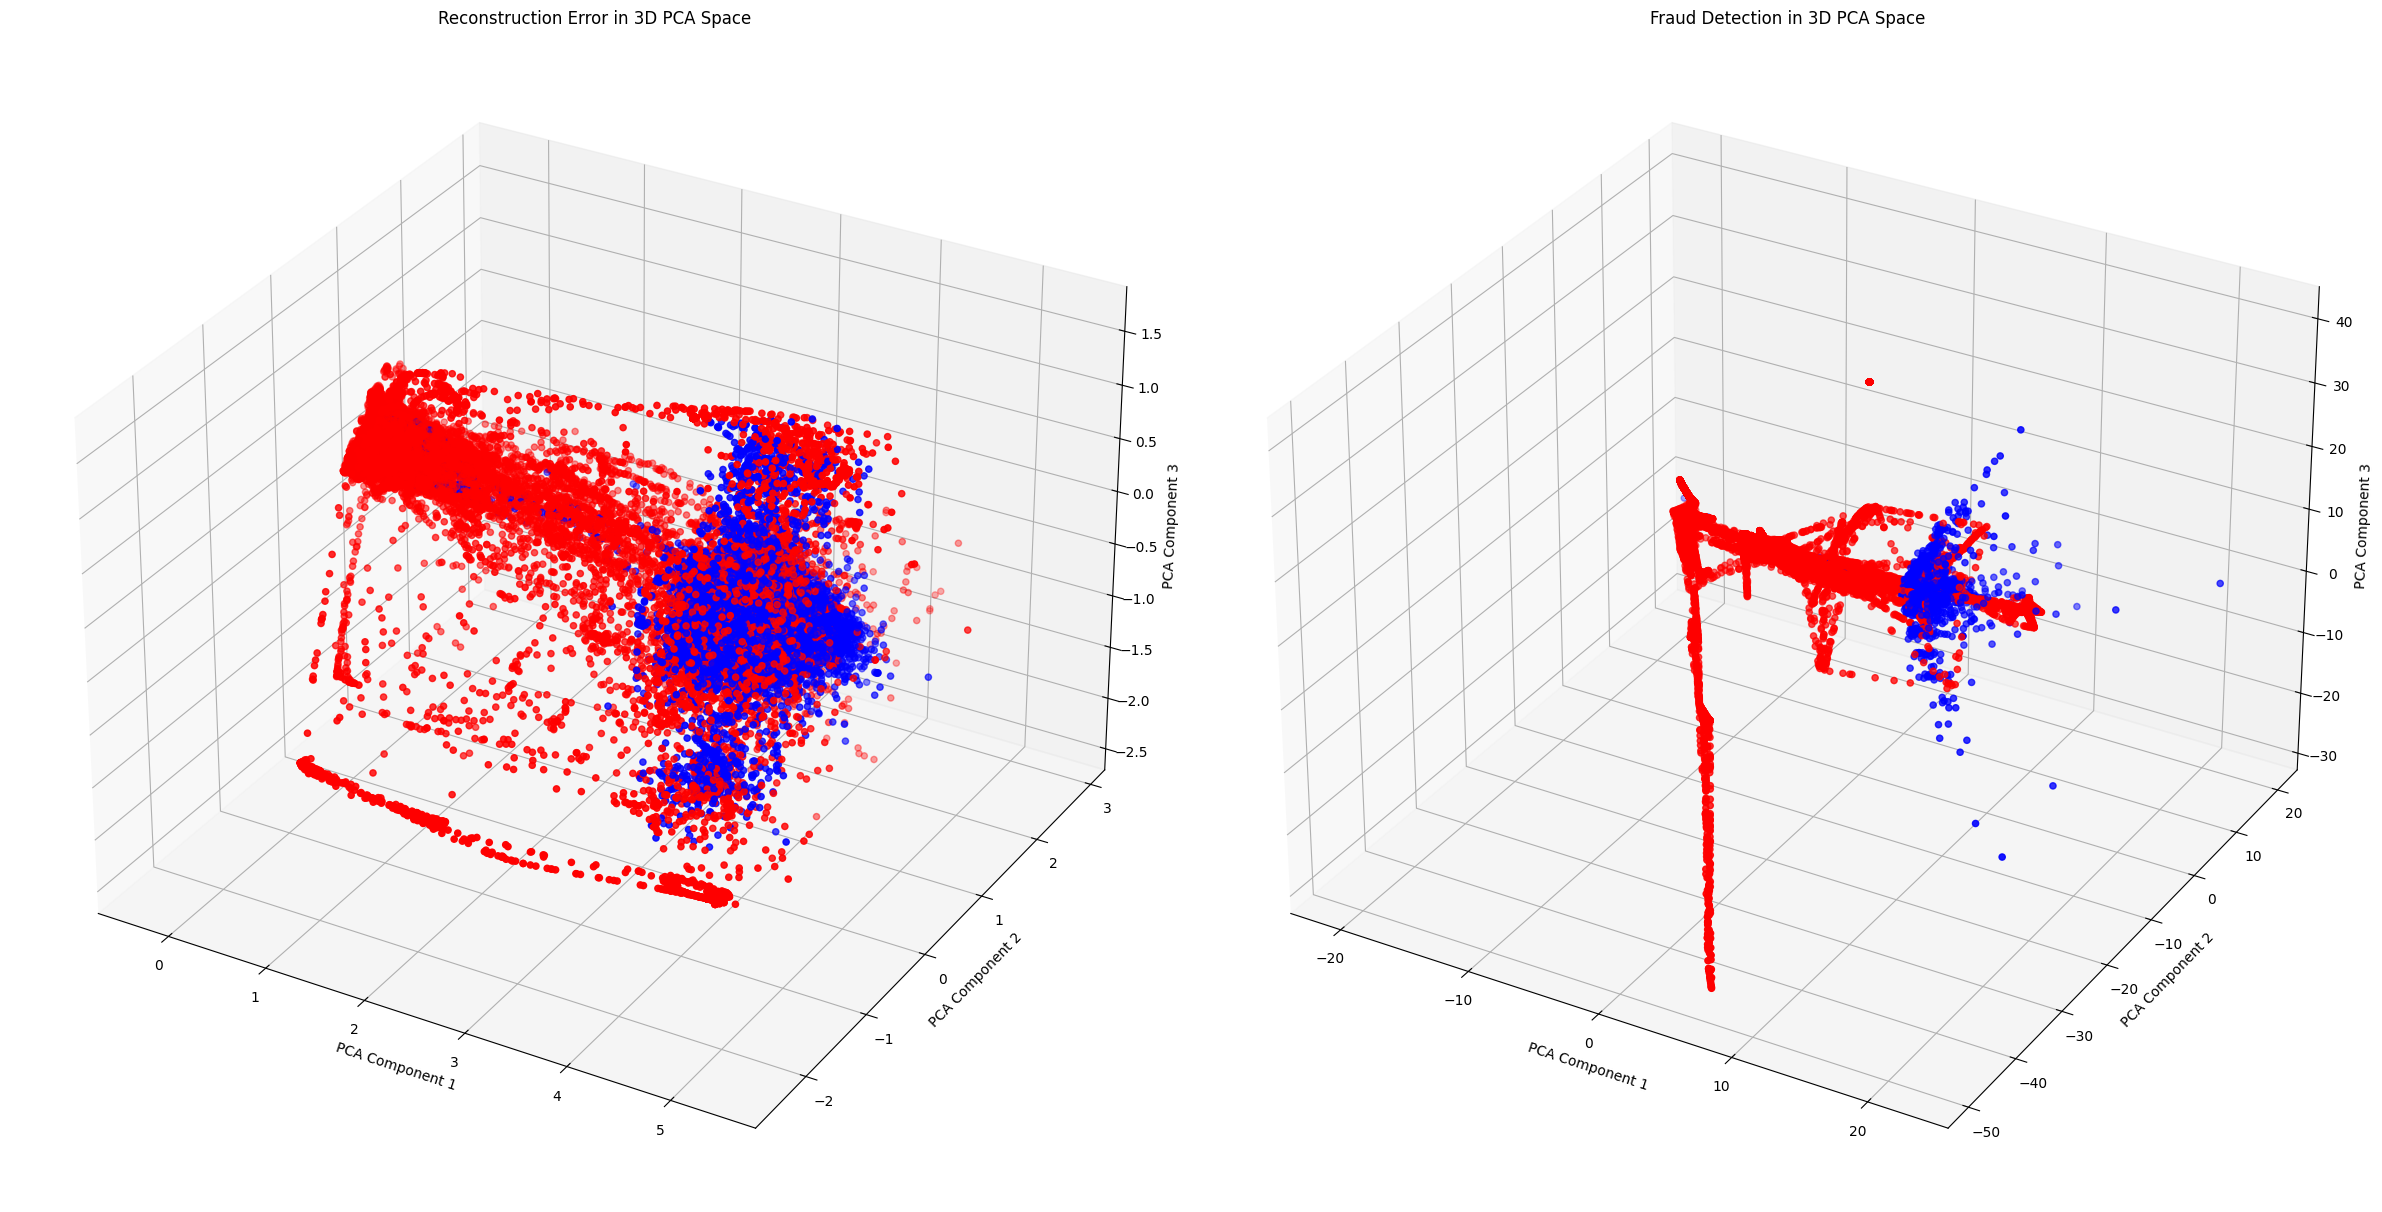

In [52]:

original_data = []

for batch in test_loader:
    X_batch, _ = batch
    original_data.append(X_batch.cpu().numpy())

original_data = np.concatenate(original_data, axis=0)

# Convert to DataFrames 
original_df = pd.DataFrame(original_data)

# Dimensionality reduction to 3 principal components using PCA
pca = PCA(n_components=3)
original_data_reduced = pca.fit_transform(original_data)
reconstructed_data_reduced = pca.transform(reconstructed_data)

# Colors for the points: 'r' for anomalies and 'b' for normals
colors_anomalies = ['r' if x else 'b' for x in anomalies.cpu().numpy()]
colors_fraud = ['r' if x == 1 else 'b' for x in y_test]

# Configure the figure and axes
fig = plt.figure(figsize=(24, 12))

# First plot: Reconstruction Error
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(reconstructed_data_reduced[:, 0], reconstructed_data_reduced[:, 1], reconstructed_data_reduced[:, 2],
                       c=colors_anomalies, marker='o')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.set_zlabel('PCA Component 3')
ax1.set_title('Reconstruction Error in 3D PCA Space')

# Second plot: Fraud Detection
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(original_data_reduced[:, 0], original_data_reduced[:, 1], original_data_reduced[:, 2],
                       c=colors_fraud, marker='o')
ax2.set_xlabel('PCA Component 1')
ax2.set_ylabel('PCA Component 2')
ax2.set_zlabel('PCA Component 3')
ax2.set_title('Fraud Detection in 3D PCA Space')

# Show the plots
plt.tight_layout()
plt.show()


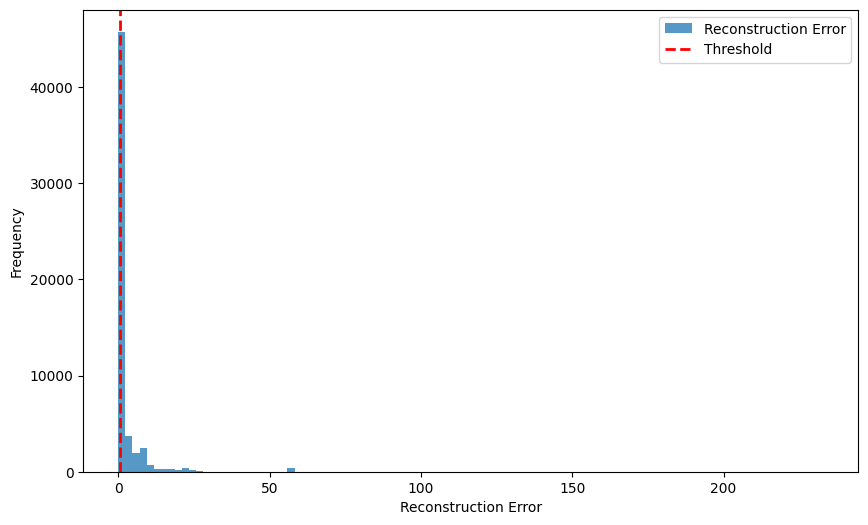

In [66]:
# Plot reconstruction error
plt.figure(figsize=(10, 6))
plt.hist(test_loss.cpu().numpy(), bins=100, alpha=0.75, label='Reconstruction Error')
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=2, label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()


Set threshold: 0.4454


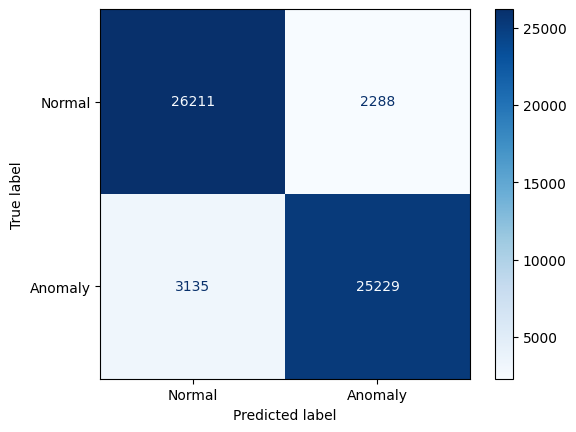

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set the model to evaluation mode
autoencoder.eval()

# Compute reconstruction errors for the test set
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    reconstructions = autoencoder(X_test_tensor)
    
    # Calculate reconstruction loss for each sample
    reconstruction_errors = torch.mean((reconstructions - X_test_tensor) ** 2, dim=1).cpu().numpy()

# Convert true labels to numpy array
y_true = y_test_tensor.cpu().numpy()
# Recycle code from above
print(f'Set threshold: {threshold:.4f}')

# Create binary labels based on the threshold
y_pred = (reconstruction_errors > threshold).astype(int)

# Convert true labels to binary if necessary
# '1' represents anomaly
y_true_binary = (y_true == 1).astype(int)  

# Compute confusion matrix
cm = confusion_matrix(y_true_binary, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap='Blues', values_format='d')

# CONCLUSION
The model's performance analysis provides valuable insights into its effectiveness. With a training accuracy of 64.36%, the model demonstrates a moderate rate of correct classifications, though in anomaly detection, precision, recall, and their balance are more critical metrics than overall accuracy. The training set loss of 0.3564, calculated using nn.MSELoss(), indicates how well the model reconstructs data, which aids in distinguishing anomalies from normal instances. The threshold of 0.4454 is used to classify anomalies, balancing between detecting true anomalies and avoiding false positives. The model identified 27,517 out of 28,364 actual anomalies, reflecting its ability to detect a large portion of true anomalies. With a recall of 88.95%, the model successfully captures a high percentage of actual anomalies, though there is room for improvement in precision, which stands at 91.69%. The F1 score of 90.30% shows a strong balance between precision and recall, but increasing precision could further enhance the model's effectiveness. To improve performance, focusing on refining the anomaly detection threshold or incorporating additional features and advanced techniques may help achieve better precision while maintaining high recall. This improvement could come in a future updates.